In [1]:
import pandas as pd

# Load the datasets
rating_csv = "/workspaces/codespaces-jupyter/data/rating.csv"
rating_df = pd.read_csv(rating_csv).sample(385, random_state=955)

movie_csv = "/workspaces/codespaces-jupyter/data/movie.csv"
movie_df = pd.read_csv(movie_csv)

# Merge the datasets
final_df = pd.merge(movie_df, rating_df, on='movieId', how='inner')

pd.set_option('display.max_columns', None)
df = final_df.drop(columns=['title', 'timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  385 non-null    int64  
 1   genres   385 non-null    object 
 2   userId   385 non-null    int64  
 3   rating   385 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 12.2+ KB


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert pipe-separated genres into space-separated strings
df['genres'] = df['genres'].str.replace('|', ' ', regex=False)

# TF-IDF transformation
tfidf = TfidfVectorizer()
tfidf_genres = tfidf.fit_transform(df['genres'])
tfidf_genres_df = pd.DataFrame(
    tfidf_genres.toarray(), 
    columns=[f"tfidf_{genre}" for genre in tfidf.get_feature_names_out()],
    index=df.index
)

# Drop and replace
df = df.drop(columns=['genres'])
df = pd.concat([df, tfidf_genres_df], axis=1)

In [3]:
import random
import numpy as np

# Store the target variable separately
y_full = df['rating']

# Create an imputation dataframe by dropping the dependent variable
imputation_df = df.drop('rating', axis=1)

# Set a random seed for reproducibility
random.seed(8)
np.random.seed(51)

# Calculate the total number of values in the dataframe
total_values = imputation_df.size

# Function to create a dataframe with a specified percentage of missing values
def create_missing_df(base_df, percent_missing):
    df_missing = base_df.copy()
    num_nulls = int(total_values * percent_missing)
    indices = [(row, col) for row in range(df_missing.shape[0]) for col in range(df_missing.shape[1])]
    random_indices = random.sample(indices, num_nulls)
    for row, col in random_indices:
        df_missing.iat[row, col] = np.nan
    return df_missing

# Create dataframes with different levels of missingness
df_5 = create_missing_df(imputation_df, 0.05)
df_10 = create_missing_df(imputation_df, 0.10)
df_15 = create_missing_df(imputation_df, 0.15)

# Display info for each dataframe
print("5% Missing Values:")
df_5.info()

print("\n10% Missing Values:")
df_10.info()

print("\n15% Missing Values:")
df_15.info()

5% Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385 entries, 0 to 384
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movieId            356 non-null    float64
 1   userId             361 non-null    float64
 2   tfidf_action       366 non-null    float64
 3   tfidf_adventure    366 non-null    float64
 4   tfidf_animation    363 non-null    float64
 5   tfidf_children     371 non-null    float64
 6   tfidf_comedy       369 non-null    float64
 7   tfidf_crime        374 non-null    float64
 8   tfidf_documentary  369 non-null    float64
 9   tfidf_drama        367 non-null    float64
 10  tfidf_fantasy      366 non-null    float64
 11  tfidf_fi           356 non-null    float64
 12  tfidf_film         362 non-null    float64
 13  tfidf_horror       368 non-null    float64
 14  tfidf_imax         370 non-null    float64
 15  tfidf_musical      367 non-null    float64
 16  tfidf_m

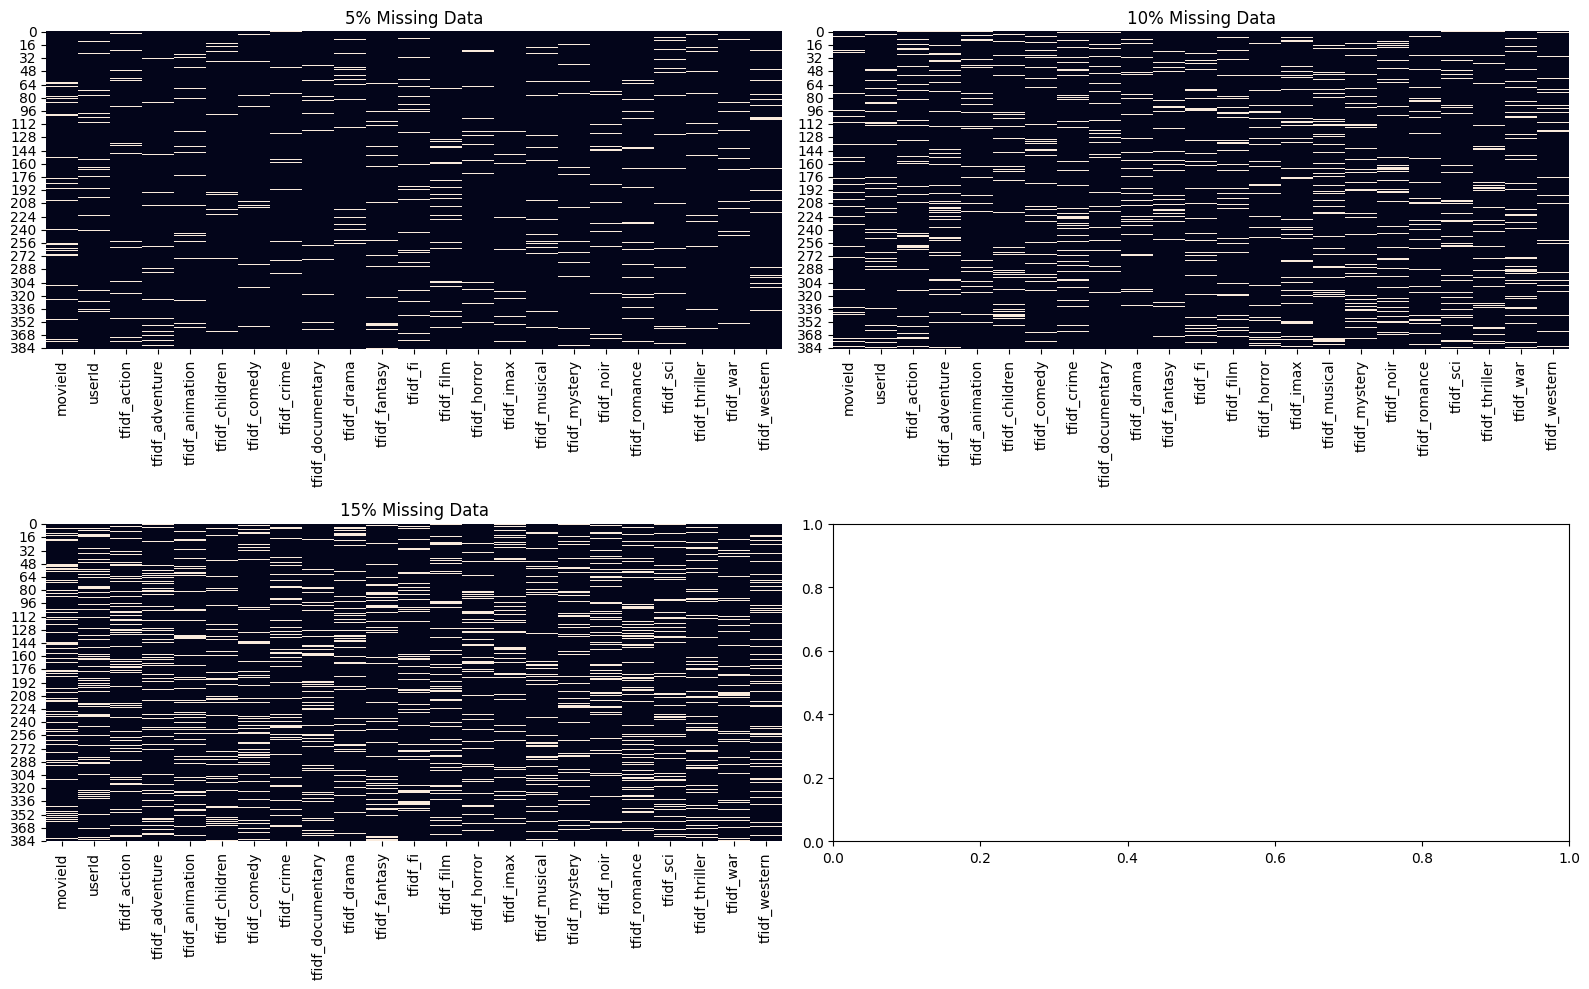

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a 2x2 grid for the heatmaps
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot each heatmap
sns.heatmap(df_5.isnull(), cbar=False, ax=axes[0, 0])
axes[0, 0].set_title('5% Missing Data')

sns.heatmap(df_10.isnull(), cbar=False, ax=axes[0, 1])
axes[0, 1].set_title('10% Missing Data')

sns.heatmap(df_15.isnull(), cbar=False, ax=axes[1, 0])
axes[1, 0].set_title('15% Missing Data')

# Improve layout
plt.tight_layout()
plt.show()

In [8]:
from sklearn.impute import SimpleImputer, KNNImputer
from fancyimpute import IterativeImputer  # for multivariate regression

# Put all missing dataframes into a dictionary for easier looping
missing_dfs = {
    '5%': df_5,
    '10%': df_10,
    '15%': df_15
}

# Store results
imputed_dfs = {}

for key, df in missing_dfs.items():
    print(f"\nProcessing {key} missing data...")

    # 1. Case-wise deletion
    #imputed_dfs[f'{key}_casewise'] = df.dropna()

    # 2. Fill with 0
    imputed_dfs[f'{key}_zero'] = df.fillna(0)

    # 3. Fill with mean
    mean_imputer = SimpleImputer(strategy='mean')
    imputed_dfs[f'{key}_mean'] = pd.DataFrame(mean_imputer.fit_transform(df), columns=df.columns)

    # 4. KNN imputation (using 5 neighbors)
    knn_imputer = KNNImputer(n_neighbors=3)
    imputed_dfs[f'{key}_knn'] = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)

    # 5. Multivariate regression imputation (IterativeImputer is MICE-based)
    mice_imputer = IterativeImputer(max_iter=5, random_state=32)
    imputed_dfs[f'{key}_regression'] = pd.DataFrame(mice_imputer.fit_transform(df), columns=df.columns)


Processing 5% missing data...

Processing 10% missing data...

Processing 15% missing data...


In [6]:
import os
import openai
import re
import ast
import time
from tqdm.notebook import tqdm
tqdm.pandas()

# Set your OpenAI API key
openai.api_key = os.environ.get("OPENAI_API_KEY") 

# Function to impute missing values using GPT
printed_example = False

def impute_with_gpt(row, df_no_missing):
    global printed_example

    if row.isnull().any():
        start_time = time.time()  # Start timing

        prompt = f"""You are a data analyst. 
            Given the following dataset:\n\n{df_no_missing.to_string(index=False)}\n\nPredict the missing values in this row 
            and return ONLY a Python dictionary with the missing fields filled in:\n{row.to_dict()}"""

        if len(prompt.split()) > 1000:
            prompt = f"""You are a data analyst. 
                Given a small sample of the dataset:\n\n{df_no_missing.head(5).to_string(index=False)}\n\nPredict the missing values in this row 
                and return ONLY a Python dictionary:\n{row.to_dict()}"""

        try:
            response = openai.ChatCompletion.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a helpful data assistant."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0
            )

            completion = response['choices'][0]['message']['content']

            if not printed_example:
                print("GPT response:\n", completion)
                printed_example = True

            match = re.search(r"\{[\s\S]*?\}", completion)
            if match:
                dict_str = match.group(0)
                imputed_values = ast.literal_eval(dict_str)
                for col in row.index:
                    if pd.isnull(row[col]) and col in imputed_values:
                        row[col] = imputed_values[col]
            else:
                if not printed_example:
                    print("No dictionary found in GPT response.")

        except Exception as e:
            if not printed_example:
                print("Error during GPT imputation:", e)

        elapsed = time.time() - start_time
        print(f"Row processed in {elapsed:.2f} seconds.")

    return row

df_5_no_missing = df_5.dropna()
df_10_no_missing = df_10.dropna()
df_15_no_missing = df_15.dropna()

df_5_llm_imputed = df_5.progress_apply(lambda row: impute_with_gpt(row, df_5_no_missing), axis=1)
df_10_llm_imputed = df_10.progress_apply(lambda row: impute_with_gpt(row, df_10_no_missing), axis=1)
df_15_llm_imputed = df_15.progress_apply(lambda row: impute_with_gpt(row, df_15_no_missing), axis=1)

imputed_dfs['5%_llm'] = df_5_llm_imputed
imputed_dfs['10%_llm'] = df_10_llm_imputed
imputed_dfs['15%_llm'] = df_15_llm_imputed

  0%|          | 0/385 [00:00<?, ?it/s]

GPT response:
 ```python
{
    'movieId': 10.0,
    'userId': 13696.0,
    'tfidf_action': 0.5687388032715287,
    'tfidf_adventure': 0.6088464870301988,
    'tfidf_animation': 0.0,
    'tfidf_children': 0.0,
    'tfidf_comedy': 0.0,
    'tfidf_crime': 0.0,  # Assuming missing value is 0.0 based on the pattern in the dataset
    'tfidf_documentary': 0.0,
    'tfidf_drama': 0.0,
    'tfidf_fantasy': 0.0,
    'tfidf_fi': 0.0,
    'tfidf_film': 0.0,
    'tfidf_horror': 0.0,
    'tfidf_imax': 0.0,
    'tfidf_musical': 0.0,
    'tfidf_mystery': 0.0,
    'tfidf_noir': 0.0,
    'tfidf_romance': 0.0,
    'tfidf_sci': 0.0,
    'tfidf_thriller': 0.5530299529720387,
    'tfidf_war': 0.0,
    'tfidf_western': 0.0
}
```
Row processed in 2.65 seconds.
Row processed in 2.20 seconds.
Row processed in 2.73 seconds.
Row processed in 9.01 seconds.
Row processed in 2.87 seconds.
Row processed in 2.86 seconds.
Row processed in 2.17 seconds.
Row processed in 2.76 seconds.
Row processed in 2.20 seconds.
Row 

  0%|          | 0/385 [00:00<?, ?it/s]

Row processed in 3.88 seconds.
Row processed in 4.70 seconds.
Row processed in 6.23 seconds.
Row processed in 5.30 seconds.
Row processed in 12.06 seconds.
Row processed in 2.83 seconds.
Row processed in 3.29 seconds.
Row processed in 3.09 seconds.
Row processed in 7.47 seconds.
Row processed in 13.75 seconds.
Row processed in 8.92 seconds.
Row processed in 4.00 seconds.
Row processed in 11.65 seconds.
Row processed in 14.09 seconds.
Row processed in 3.00 seconds.
Row processed in 9.61 seconds.
Row processed in 3.02 seconds.
Row processed in 3.68 seconds.
Row processed in 9.71 seconds.
Row processed in 3.58 seconds.
Row processed in 7.73 seconds.
Row processed in 24.60 seconds.
Row processed in 11.82 seconds.
Row processed in 8.05 seconds.
Row processed in 8.38 seconds.
Row processed in 2.89 seconds.
Row processed in 2.96 seconds.
Row processed in 2.53 seconds.
Row processed in 3.13 seconds.
Row processed in 8.34 seconds.
Row processed in 2.92 seconds.
Row processed in 3.14 seconds.
Ro

  0%|          | 0/385 [00:00<?, ?it/s]

Row processed in 7.04 seconds.
Row processed in 9.62 seconds.
Row processed in 5.17 seconds.
Row processed in 3.28 seconds.
Row processed in 7.83 seconds.
Row processed in 14.97 seconds.
Row processed in 13.12 seconds.
Row processed in 11.25 seconds.
Row processed in 4.01 seconds.
Row processed in 3.42 seconds.
Row processed in 3.02 seconds.
Row processed in 10.98 seconds.
Row processed in 17.79 seconds.
Row processed in 12.74 seconds.
Row processed in 9.14 seconds.
Row processed in 7.28 seconds.
Row processed in 5.38 seconds.
Row processed in 7.03 seconds.
Row processed in 1.47 seconds.
Row processed in 4.12 seconds.
Row processed in 4.68 seconds.
Row processed in 14.91 seconds.
Row processed in 3.61 seconds.
Row processed in 4.64 seconds.
Row processed in 5.63 seconds.
Row processed in 3.69 seconds.
Row processed in 4.09 seconds.
Row processed in 6.62 seconds.
Row processed in 13.57 seconds.
Row processed in 8.59 seconds.
Row processed in 4.34 seconds.
Row processed in 3.40 seconds.


In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import category_encoders as ce

regression_results = {}

for name, imputed_df in imputed_dfs.items():
    print(f"\nRunning model for {name} imputed data...")
    X = imputed_df.copy()
    y = y_full.reindex(X.index)

    valid_idx = y.notnull()
    X = X[valid_idx].dropna()
    y = y.loc[X.index]

    kf = KFold(n_splits=5, shuffle=True, random_state=7)
    y_pred = np.zeros(len(X))

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
        y_train = y.iloc[train_idx]

        # Target encoding within the fold
        encoder = ce.TargetEncoder(cols=['userId', 'movieId'], smoothing=5.0)
        encoder.fit(X_train[['userId', 'movieId']], y_train)

        X_train_encoded = encoder.transform(X_train[['userId', 'movieId']])
        X_val_encoded = encoder.transform(X_val[['userId', 'movieId']])

        # Replace original IDs with encoded
        X_train.update(X_train_encoded)
        X_val.update(X_val_encoded)

        # Train model
        model = GradientBoostingRegressor(
            n_estimators=150, 
            learning_rate=0.1, 
            max_depth=4, 
            random_state=72
        )
        model.fit(X_train, y_train)
        y_pred[val_idx] = model.predict(X_val)

    # Evaluate
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)

    regression_results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    }

# Display results
results_5 = {method: results for method, results in regression_results.items() if method.startswith('5%')}
results_10 = {method: results for method, results in regression_results.items() if method.startswith('10%')}
results_15 = {method: results for method, results in regression_results.items() if method.startswith('15%')}

# Convert the dictionaries into DataFrames
df_5_results = pd.DataFrame(results_5).T
df_10_results = pd.DataFrame(results_10).T
df_15_results = pd.DataFrame(results_15).T

# Display the results
print("\nRegression Results for 5% Missing Data:")
print(df_5_results[['MAE', 'MSE', 'RMSE']].round(4))

print("\nRegression Results for 10% Missing Data:")
print(df_10_results[['MAE', 'MSE', 'RMSE']].round(4))

print("\nRegression Results for 15% Missing Data:")
print(df_15_results[['MAE', 'MSE', 'RMSE']].round(4))


Running model for 5%_zero imputed data...

Running model for 5%_mean imputed data...

Running model for 5%_knn imputed data...

Running model for 5%_regression imputed data...

Running model for 10%_zero imputed data...

Running model for 10%_mean imputed data...

Running model for 10%_knn imputed data...

Running model for 10%_regression imputed data...

Running model for 15%_zero imputed data...

Running model for 15%_mean imputed data...

Running model for 15%_knn imputed data...

Running model for 15%_regression imputed data...

Regression Results for 5% Missing Data:
                  MAE     MSE    RMSE
5%_zero        0.8110  1.1219  1.0592
5%_mean        0.8089  1.1184  1.0575
5%_knn         0.8068  1.1162  1.0565
5%_regression  0.7989  1.0914  1.0447

Regression Results for 10% Missing Data:
                   MAE     MSE    RMSE
10%_zero        0.8021  1.0978  1.0478
10%_mean        0.8062  1.1057  1.0515
10%_knn         0.7985  1.0921  1.0450
10%_regression  0.7987  1.0913  